This notebook is a implementation of getting started with cyclicLR. The model and pipelines are from 
https://www.pyimagesearch.com/2019/07/29/cyclical-learning-rates-with-keras-and-deep-learning/ .

I only created a wrapper to get started with cyclicLR. To know what cyclicLR check out my other notebbok
in this repo. To implement toy dataset with cyclicLR continue here and run all.

In [0]:
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K
import numpy as np


class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency.
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch."""

    def __init__(
            self,
            base_lr=0.001,
            max_lr=0.006,
            step_size=2000.,
            mode='triangular',
            gamma=1.,
            scale_fn=None,
            scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        if mode not in ['triangular', 'triangular2',
                        'exp_range']:
            raise KeyError("mode must be one of 'triangular', "
                           "'triangular2', or 'exp_range'")
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn is None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1 / (2.**(x - 1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma ** x
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr is not None:
            self.base_lr = new_base_lr
        if new_max_lr is not None:
            self.max_lr = new_max_lr
        if new_step_size is not None:
            self.step_size = new_step_size
        self.clr_iterations = 0.

    def clr(self):
        cycle = np.floor(1 + self.clr_iterations / (2 * self.step_size))
        x = np.abs(self.clr_iterations / self.step_size - 2 * cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr - self.base_lr) * \
                np.maximum(0, (1 - x)) * self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr - self.base_lr) * \
                np.maximum(0, (1 - x)) * self.scale_fn(self.clr_iterations)

    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())

    def on_batch_end(self, epoch, logs=None):

        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1
        K.set_value(self.model.optimizer.lr, self.clr())

        self.history.setdefault(
            'lr', []).append(
            K.get_value(
                self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

CLASSES = ["airplane", "automobile", "bird", "cat", "deer", "dog",
	"frog", "horse", "ship", "truck"]

# define the minimum learning rate, maximum learning rate, batch size,
# step size, CLR method, and number of epochs
MIN_LR = 1e-7
MAX_LR = 1e-2
BATCH_SIZE = 64
STEP_SIZE = 8
CLR_METHOD = "triangular"
NUM_EPOCHS = 24

In [2]:

import matplotlib
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import cifar10
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model


print("[INFO] loading CIFAR-10 data...")
((trainX, trainY), (testX, testY)) = cifar10.load_data()
trainX = trainX.astype("float")
testX = testX.astype("float")

mean = np.mean(trainX, axis=0)
trainX -= mean
testX -= mean


lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

# construct the image generator for data augmentation
aug = ImageDataGenerator()

print("[INFO] compiling model...")
opt = SGD(lr=MIN_LR, momentum=0.9)
model=load_model('cifar.h5')
####  LR TRACKERRRR ##########
def lrtracker(true,pred):
	return model.optimizer.lr
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy",lrtracker])

print("[INFO] using '{}' method".format(CLR_METHOD))
clr = CyclicLR(
	mode=CLR_METHOD,
	base_lr=MIN_LR,
	max_lr=MAX_LR,
	step_size= STEP_SIZE * (trainX.shape[0] // BATCH_SIZE))


[INFO] loading CIFAR-10 data...


W0801 09:40:09.505534 140204777727872 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0801 09:40:09.508143 140204777727872 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0801 09:40:09.509750 140204777727872 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtyp

[INFO] compiling model...
[INFO] using 'triangular' method


In [3]:
# train the network
print("[INFO] training network...")
H = model.fit_generator(
	aug.flow(trainX, trainY, batch_size=BATCH_SIZE),
	validation_data=(testX, testY),
	steps_per_epoch=trainX.shape[0] // BATCH_SIZE,
	epochs=NUM_EPOCHS,
	callbacks=[clr],
	verbose=1)


[INFO] training network...
Epoch 1/24
781/781 [==============================] - 50s 64ms/step - loss: 1.9573 - acc: 0.2883 - lrtracker: 6.2429e-04 - val_loss: 1.7932 - val_acc: 0.3687 - val_lrtracker: 0.0013
Epoch 2/24
781/781 [==============================] - 43s 55ms/step - loss: 1.3358 - acc: 0.5150 - lrtracker: 0.0019 - val_loss: 1.1711 - val_acc: 0.5781 - val_lrtracker: 0.0025
Epoch 3/24
781/781 [==============================] - 43s 55ms/step - loss: 1.0659 - acc: 0.6185 - lrtracker: 0.0031 - val_loss: 1.1306 - val_acc: 0.6095 - val_lrtracker: 0.0038
Epoch 4/24
781/781 [==============================] - 43s 55ms/step - loss: 0.8964 - acc: 0.6832 - lrtracker: 0.0044 - val_loss: 1.1783 - val_acc: 0.5786 - val_lrtracker: 0.0050
Epoch 5/24
781/781 [==============================] - 43s 55ms/step - loss: 0.7633 - acc: 0.7344 - lrtracker: 0.0056 - val_loss: 0.8541 - val_acc: 0.7058 - val_lrtracker: 0.0063
Epoch 6/24
781/781 [==============================] - 43s 55ms/step - loss: 0.6

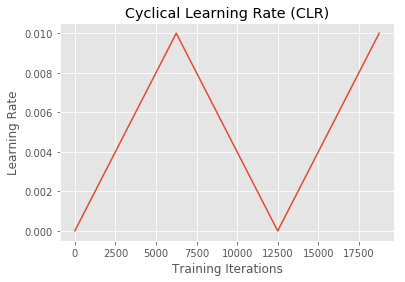

In [4]:
plt.style.use("ggplot")

# plot the learning rate history
N = np.arange(0, len(clr.history["lr"]))
plt.figure()
plt.plot(N, clr.history["lr"])
plt.title("Cyclical Learning Rate (CLR)")
plt.xlabel("Training Iterations")
plt.ylabel("Learning Rate")
plt.savefig('lrhistory1.png')